In [103]:
%reload_ext autoreload
%autoreload 2
%matplotlib widget

In [104]:
import matplotlib.pyplot as plt
import numpy as np
import torch

In [105]:
import bnn.functions
import bnn.network
import bnn.layer
import bnn.loss
import bnn.optimizer

In [106]:
dims = [1, 10, 10, 4]
TBNN = bnn.network.TernBinNetwork(*dims, forward_func=bnn.functions.forward.LayerMedianBinarise())

In [107]:
TBNN._initialise(W_mean=0, W_zero_prob=1)

In [108]:
samples = 100
input = bnn.functions.binarise(torch.randn(samples, 1).to(torch.int))
desired = torch.stack(
    [input[..., 0], -input[..., 0], torch.ones(samples, dtype=torch.int), -torch.ones(samples, dtype=torch.int)],
    dim=-1
)
desired.shape

torch.Size([100, 4])

In [109]:
loss_func: bnn.loss.LossFunction = bnn.loss.l1

In [110]:
train_epochs = 100

In [111]:
BernOpt = bnn.optimizer.ExpectationSGD(TBNN.parameters(), lr=0.001)

In [112]:
losses = []
for epoch in range(train_epochs):
    # forward pass
    output = TBNN.forward(input)
    loss = loss_func.forward(output=output, target=desired)
    losses.append(loss)

    # backward pass
    grad = loss_func.backward(output=output, target=desired)
    out_grad = TBNN.backward(grad)

    # optimizer step
    BernOpt.step(number_of_samples=len(input))

    early_exit = loss == 0

    if early_exit or (epoch % 1) == 0:
        print(f"epoch: {epoch}\tloss: {loss}")

    if early_exit:
        break

epoch: 0	loss: 400
epoch: 1	loss: 244
epoch: 2	loss: 244
epoch: 3	loss: 244
epoch: 4	loss: 400
epoch: 5	loss: 400
epoch: 6	loss: 244
epoch: 7	loss: 244
epoch: 8	loss: 244
epoch: 9	loss: 400
epoch: 10	loss: 400
epoch: 11	loss: 400
epoch: 12	loss: 378
epoch: 13	loss: 378
epoch: 14	loss: 200
epoch: 15	loss: 244
epoch: 16	loss: 244
epoch: 17	loss: 200
epoch: 18	loss: 400
epoch: 19	loss: 244
epoch: 20	loss: 200
epoch: 21	loss: 200
epoch: 22	loss: 200
epoch: 23	loss: 200
epoch: 24	loss: 400
epoch: 25	loss: 244
epoch: 26	loss: 244
epoch: 27	loss: 244
epoch: 28	loss: 244
epoch: 29	loss: 422
epoch: 30	loss: 422
epoch: 31	loss: 244
epoch: 32	loss: 400
epoch: 33	loss: 400
epoch: 34	loss: 400
epoch: 35	loss: 200
epoch: 36	loss: 200
epoch: 37	loss: 200
epoch: 38	loss: 200
epoch: 39	loss: 200
epoch: 40	loss: 200
epoch: 41	loss: 200
epoch: 42	loss: 200
epoch: 43	loss: 400
epoch: 44	loss: 200
epoch: 45	loss: 200
epoch: 46	loss: 378
epoch: 47	loss: 378
epoch: 48	loss: 200
epoch: 49	loss: 200
epoch: 50	

In [113]:
TBNN.forward(-torch.ones(1, 1, dtype=torch.int))

tensor([[ 1,  1,  1, -1]], dtype=torch.int32)

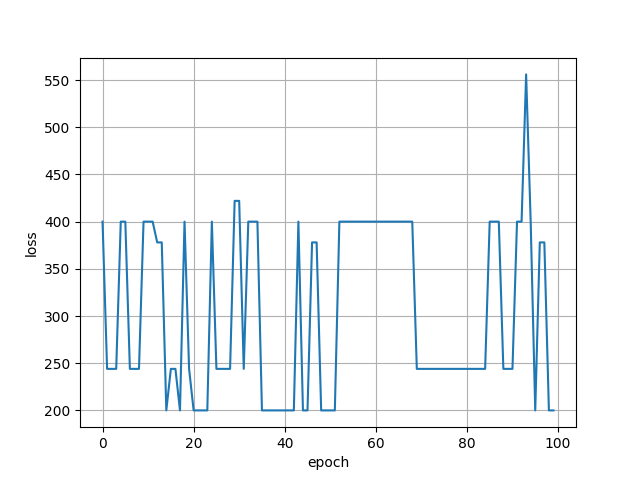

In [114]:
NAME = "loss_curve"
plt.close(NAME)
plt.figure(NAME)

plt.plot(losses)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()

plt.show()

In [115]:
for name, p in TBNN.named_parameters():
    if name.lower().endswith(".w"):
        print(name, p)

layers.TernBinLayer0.W Parameter containing:
tensor([[ 1,  1,  1,  1, -1,  1,  1,  1,  1,  1]], dtype=torch.int32)
layers.TernBinLayer1.W Parameter containing:
tensor([[ 1, -1,  1,  1,  1,  1,  1, -1, -1,  1],
        [ 1, -1,  1,  1,  1,  1,  1, -1, -1,  1],
        [ 1, -1,  1,  1,  1,  1,  1, -1, -1,  1],
        [ 1, -1,  1,  1,  1,  1,  1, -1, -1,  1],
        [-1,  1, -1, -1, -1, -1, -1,  1,  1, -1],
        [ 1, -1,  1,  1,  1,  1,  1, -1, -1,  1],
        [ 1, -1,  1,  1,  1,  1,  1, -1, -1,  1],
        [ 1, -1,  1,  1,  1,  1,  1, -1, -1,  1],
        [ 1, -1,  1,  1,  1,  1,  1, -1, -1,  1],
        [ 1, -1,  1,  1,  1,  1,  1, -1, -1,  1]], dtype=torch.int32)
layers.TernBinLayer2.W Parameter containing:
tensor([[-1, -1,  0, -1],
        [ 1,  1,  0,  1],
        [ 0, -1,  0, -1],
        [-1,  0,  0, -1],
        [-1, -1,  0, -1],
        [-1, -1,  0, -1],
        [ 1, -1,  0, -1],
        [ 1,  1,  0,  1],
        [ 1,  1,  0,  1],
        [-1, -1,  0, -1]], dtype=torch.in